# Reflect Tables into SQLAlchemy ORM

In [1]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [2]:
import numpy as np
import pandas as pd
import datetime
from datetime import datetime, timedelta

In [3]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect, DateTime, MetaData

In [4]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///Resources/hawaii.sqlite")

In [5]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [6]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [7]:
# Save references to each table
station = Base.classes.station
measurement = Base.classes.measurement

In [8]:
# Create our session (link) from Python to the DB
session = Session(engine)

# Exploratory Precipitation Analysis

In [9]:
inspector = inspect(engine)
inspector.get_table_names()
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

In [10]:
# Find the most recent date in the data set.
session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

'2017-08-23'

In [11]:
metadata = MetaData()
metadata.reflect(bind=engine)

measurement_table = metadata.tables['measurement']
measurement_table.columns['date'].type = DateTime()

with engine.connect() as connection:
    metadata.create_all(bind=engine)

In [12]:
inspector.get_columns('measurement')

[{'name': 'id',
  'type': INTEGER(),
  'nullable': False,
  'default': None,
  'primary_key': 1},
 {'name': 'station',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'date',
  'type': TEXT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'prcp',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0},
 {'name': 'tobs',
  'type': FLOAT(),
  'nullable': True,
  'default': None,
  'primary_key': 0}]

In [13]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
most_recent = session.query(measurement.date).order_by(measurement.date.desc()).first()[0]
most_recent_date = datetime.strptime(most_recent, '%Y-%m-%d').date()
# Calculate the date one year from the last date in data set.
minus_one_year = most_recent_date - timedelta(days=365)
print(minus_one_year)

# Perform a query to retrieve the data and precipitation scores
last_year = session.query(measurement.date, measurement.prcp).filter(measurement.date > minus_one_year).all()
last_year

# Save the query results as a Pandas DataFrame. Explicitly set the column names
pandas_last_year = pd.DataFrame(last_year, columns=['date', 'precipitation'])
pandas_last_year

# Sort the dataframe by date
sorted_pd_last_year = pandas_last_year.sort_values(by='date')
sorted_pd_last_year


2016-08-23


,date,precipitation
0,2016-08-24,0.08
1006,2016-08-24,NaN
1524,2016-08-24,2.15
702,2016-08-24,2.28
360,2016-08-24,2.15
...,...,...
1522,2017-08-22,0.00
1523,2017-08-23,0.08
359,2017-08-23,0.00
1005,2017-08-23,0.00


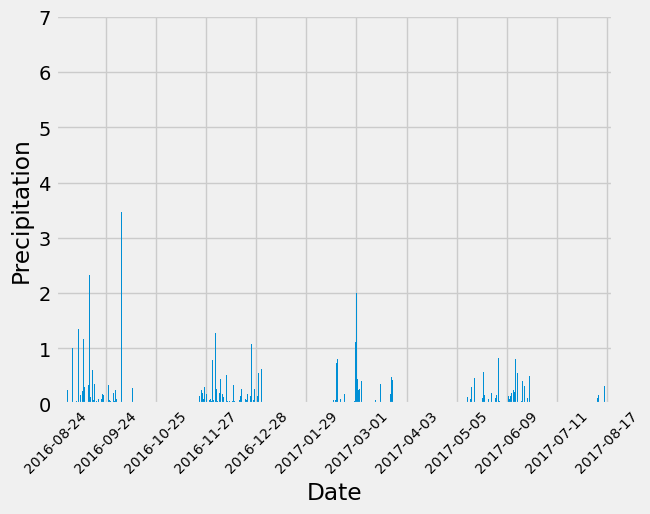

In [14]:
# Use Pandas Plotting with Matplotlib to plot the data
base_plot = sorted_pd_last_year.plot('date', 'precipitation', kind='bar', legend=False)
base_plot.set_xticks(base_plot.get_xticks()[::200])
base_plot.set_xticklabels(sorted_pd_last_year['date'][::200], rotation=45, fontsize=10)
plt.xlabel('Date')
plt.ylabel('Precipitation')
plt.show()

In [15]:
# Use Pandas to calculate the summary statistics for the precipitation data
sorted_pd_last_year.describe()

,precipitation
count,2015.000000
mean,0.176462
std,0.460288
min,0.000000
25%,0.000000
50%,0.020000
75%,0.130000
max,6.700000


# Exploratory Station Analysis

In [16]:
# Design a query to calculate the total number of stations in the dataset
session.query(func.count(func.distinct(measurement.station))).all()
# session.query(measurement.date).order_by(measurement.date.desc()).first()[0]

[(9,)]

In [17]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
session.query(measurement.station, func.count()).group_by(measurement.station).order_by(func.count().desc()).all()

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [18]:
most_active_station = session.query(measurement.station, func.count()).group_by(measurement.station).order_by(func.count().desc()).all()[0][0]
most_active_station

'USC00519281'

In [19]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
session.query(func.min(measurement.tobs), func.max(measurement.tobs), func.avg(measurement.tobs)).filter(measurement.station == most_active_station).group_by(measurement.station).all()

[(54.0, 85.0, 71.66378066378067)]

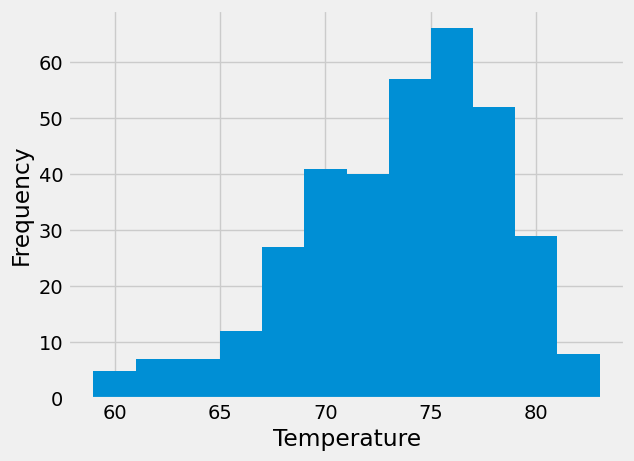

In [21]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
last_year_temps = session.query(measurement.date, measurement.tobs).filter(measurement.date > minus_one_year, measurement.station == most_active_station).all()
last_year_temps

# Save the query results as a Pandas DataFrame. Explicitly set the column names
pandas_last_year_temps = pd.DataFrame(last_year_temps, columns=['date', 'temperature'])
pandas_last_year_temps

plt.hist(pandas_last_year_temps['temperature'], bins=12)
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.show()

# Close Session

In [22]:
# Close Session
session.close()